# Business Understanding

- [ ] analysis of requirements with the end user
- [ ] definition of business goals
- [ ] translation of business goals into data mining goals
- [ ] Tools and project management

## Business Objectives

**Descriptive problem**: TODO

**Predictive problem**: Predict whether a loan will end successfully.

- Classification problem
- Target: *status* column of *loan_dev.csv* file (-1 = bad, 1 = good)
- Minority (positive) class: Loan not paid (*status* = -1)
- Evaluation metric: AUC
- Reduce defaulting (minimize FPR), for example FPR < 0.25
- Don't reduce credit card approval (maximize FNR), for example FNR > 0.95


## ~~Assess Situation~~

## Data Mining Goals (TODO)

Parte disto deve estar em Business Objectives, mas não sei o que é o quê

## Project Plan (TODO)

- Methodology: CRISP-DM
- plan: TODO ?????????
- Project Management tools: ??????
- collaboration tools: Github? (idk if this is what they mean)
- Analytics Tools: ?????
- Database Tools: ?????
- other tools (e.g. data cleaning, visualization): ????


    

# Data Understanding
    
- [ ] diversity of statistical methods
- [ ] complexity of statistical methods
- [ ] interpretation of results of statistical methods
- [ ] knowledge extraction from results of statistical methods
- [ ] diversity of plots
- [ ] complexity of plots
- [ ] presentation
- [ ] interpretation of plots
- [ ] visual knowledge extraction

## Collected Data

- account.csv - relation account (4500 objects) 
- client.csv - relation client (5369 objects)
- disp.csv - relation disposition (5369 objects) 
- district.csv - relation demographic data (77 objects)
- ~~relation permanent order (0/6471 objects)~~
- trans_dev.csv - relation transaction (396685/1056320 objects)
- card_dev.csv - relation credit card (177/892 objects)
- loan_dev.csv - relation loan (328/682 objects)



In [3]:
import os
import uuid
import numpy as np 
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# This is used in order to show the plotted figures within this notebook
%matplotlib inline 
# This is used in order to show the tensorboard within this notebook             
#%load_ext tensorboard  
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
import missingno as msno


In [4]:
accounts = pd.read_csv('data/account.csv', sep=';')
cards_dev = pd.read_csv('data/card_dev.csv', sep=';')
clients = pd.read_csv('data/client.csv', sep=';')
disp = pd.read_csv('data/disp.csv', sep=';')
districts = pd.read_csv('data/district.csv', sep=';')
loans_dev = pd.read_csv('data/loan_dev.csv', sep=';')
trans_dev = pd.read_csv('data/trans_dev.csv', sep=';')

C:\Users\PedroGoncaloCorreia\AppData\Local\Temp\ipykernel_2032\1239521831.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_dev = pd.read_csv('data/trans_dev.csv', sep=';')


In [13]:
def info(table, name):
    print("==============")
    print(name)
    print("--------------")
    print(table.info(verbose=True, max_cols=1000, memory_usage=False, show_counts=True))

info(accounts, "accounts")
info(cards_dev, "cards_dev")
info(clients, "clients")
info(disp, "disp")
info(districts, "districts")
info(loans_dev, "loans_dev")
info(trans_dev, "transactions_dev")


accounts
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   int64 
dtypes: int64(3), object(1)None
cards_dev
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  177 non-null    int64 
 1   disp_id  177 non-null    int64 
 2   type     177 non-null    object
 3   issued   177 non-null    int64 
dtypes: int64(3), object(1)None
clients
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  ----

Only transactions_dev has null values: operation, k_symbol, bank, account

accounts : 4500 objects
 #  | Column    |   Non-Null Count | type 
--- | ------     |  -------------- | ----- 
 0 |  account_id  | 4500 non-null |  PRIMARY KEY 
 1  | district_id|  4500 non-null |  FOREIGN KEY 
 2  | frequency  |  4500 non-null |  enum('monthly issuance', 'issuance after transaction', 'weekly issuance')
 3  | date       |  4500 non-null |  YYMMDD

- categorize/encode frequency, no order (TODO: why no order? there seems to be a order: after < weekly < monthly)
- parse date
- join on acc_id and distr_id

clients : 5369 objects
 #  | Column        |Non-Null Count|  type
--- | ------        |--------------|  -----
 0  | client_id     |5369 non-null |  PRIMARY KEY
 1  | birth_number | 5369 non-null |  YYMMDD + 5000 if woman
 2   |district_id |  5369 non-null |  FOREIGN KEY

- parse birth date
- retrieve sex and birth_date from birth_number

disp : 5369 objects
 #  | Column     | Non-Null Count | type 
--- | ------     | -------------- | ----- 
 0  | disp_id    | 5369 non-null  | PRIMARY KEY 
 1  | client_id  | 5369 non-null  | FOREIGN KEY 
 2  | account_id | 5369 non-null  | FOREIGN KEY 
 3  | type       | 5369 non-null  | enum('OWNER', 'DISPONENT')

- categorize/encode frequency, (0 = disponent, 1 = owner)

districts : 77 objects
 #  | Column                                            | Non-Null Count | type  
--- | ------                                            | -------------- | -----  
 0  | code                                              | 77 non-null    | PRIMARY KEY  
 1  | name                                              | 77 non-null    | object 
 2  | region                                            | 77 non-null    | object 
 3  | no. of inhabitants                                | 77 non-null    | int64  
 4  | no. of municipalities with inhabitants < 499      | 77 non-null    | int64  
 5  | no. of municipalities with inhabitants 500-1999   | 77 non-null    | int64  
 6  | no. of municipalities with inhabitants 2000-9999  | 77 non-null    | int64  
 7  | no. of municipalities with inhabitants >10000     | 77 non-null    | int64  
 8  | no. of cities                                     | 77 non-null    | int64  
 9  | ratio of urban inhabitants                       |  77 non-null    | float64
 10 | average salary                                  |   77 non-null    | int64  
 11 | unemploymant rate '95                          |    77 non-null    | object 
 12 | unemploymant rate '96                         |     77 non-null    | float64
 13 | no. of enterpreneurs per 1000 inhabitants    |      77 non-null    | int64  
 14 | no. of commited crimes '95                  |       77 non-null    | object 
 15 | no. of commited crimes '96                 |        77 non-null    | int64  

transactions_dev : 396685/1056320 objects
 #  | Column    |  Non-Null Count |  type  
--- | ------    |  -------------- |  -----  
 0  | trans_id  |  396685 non-null|  PRIMARY KEY  
 1  | account_id|  396685 non-null|  FOREIGN KEY  
 2  | date      |  396685 non-null|  YYMMDD
 3  | type      |  396685 non-null|  enum('credit', 'withdrawal', 'withdrawal in cash') 
 4  | operation |  325924 non-null|  enum('credit in cash', 'collection from another bank', 'withdrawal in cash', 'remittance to another bank', 'credit card withdrawal')
 5  | amount    |  396685 non-null|  float64 (currency unit)
 6  | balance   |  396685 non-null|  float64 (currency unit)
 7  | k_symbol  |  211441 non-null|  enum('interest credited', ' ', 'household', 'payment for statement', 'insurrance payment', 'sanction interest if negative balance', 'old-age pension')
 8  | bank      |  97242 non-null |  string (other bank ID)
 9  | account   |  102229 non-null|  account (other bank's account ID)

- type="withdrawal in cash" is redundant with operation="withdrawal in cash"
- parse date
- encode type, operation, bank
- handle nulls on operation, k_symbol, bank and account

cards_dev : 177/892 objects
 #  | Column  | Non-Null Count | type 
--- | ------  | -------------- | ----- 
 0  | card_id | 177 non-null   | PRIMARY KEY 
 1  | disp_id | 177 non-null   | FOREIGN KEY 
 2  | type    | 177 non-null   | object
 3  | issued  | 177 non-null   | int64 


loans_dev : 328/682 objects
 #  | Column     | Non-Null Count | type
--- | ------     | -------------- | -----
 0  | loan_id    | 328 non-null   | PRIMARY KEY
 1  | account_id | 328 non-null   | FOREIGN KEY
 2  | date       | 328 non-null   | int64
 3  | amount     | 328 non-null   | int64
 4  | duration   | 328 non-null   | int64
 5  | payments   | 328 non-null   | int64
 6  | **status** |     328 non-null  |  int64


<AxesSubplot:>

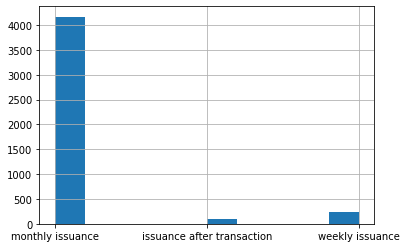

In [14]:
accounts['frequency'].hist()

<AxesSubplot:>

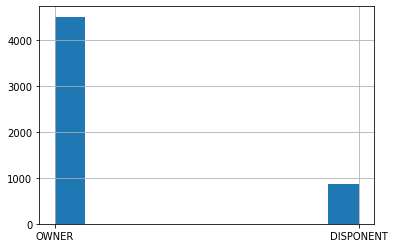

In [15]:
disp['type'].hist()

In [ ]:
msno.heatmap(trans_dev)